In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

Notation: 
* SF = scale free
* ER = Erdosh Renyi

In [2]:
### PARAMETERS ###
N = 1000
k0 = 2
p_mob = 0.05
eps = 0.1
beta = 0.09
mu = 0.05 # change this, it's the most unreasonable estimate
gamma = 0.01

In [3]:
G_sf = nx.barabasi_albert_graph(N,k0) #number of nodes, number of links added for each node
mean_deg_sf = sum([k for i, k in G_sf.degree()])/len(G_sf.degree())
print("K0: \t", k0)
print("Kmean: ", mean_deg_sf)

K0: 	 2
Kmean:  3.992


In [4]:
p = k0/N*2 # prob of creating an edge
G_er = nx.binomial_graph(N,p)
mean_deg_er = sum([k for i, k in G_er.degree()])/len(G_er.degree())
print("Kmean: ", mean_deg_er)

Kmean:  3.998


Now we get the adjacency matrices

In [5]:
A_sf = nx.to_numpy_matrix(G_sf)
A_er = nx.to_numpy_matrix(G_er)

In [54]:
def SIRS_step(A, state, beta, mu, gamma, T=0.5, debug=False):
    """
    SIRS step for a single network. Updated A and state needs to be computed
    before calling this function (take into account mobility + dynamic contacts).
    Works with synchronous update (e.g. new infected cannot recover in this step).
    
    Parameters
    ----------
    - A : adjacency matrix
    - state : 
        state[:,0] = 1 for the susceptible, 0 for the others
        state[:,1] = 1 for the infected, 0 for the others
        state[:,2] = 1 for the recovered, 0 for the others
    - beta : prob of infection given contact
    - mu : prob of recovery per step
    - gamma : prob of S->R transition per step
    - T : fraction of the day spent in the system
    
    Return
    ------
    state, recovered (updated)
    """
    N = len(state)
    new_state = np.zeros((N,3))
    
    dprint = print if debug else lambda *args, **kwargs : None
        
    ### S -> I ###
    p_I = beta*np.matmul(A,state[:,1]).T # prob of getting the infection
    p_I = np.array(p_I).reshape(N)
    u = np.random.rand(N) 
    mask_S = (u < p_I*state[:,0]) # apply only to susceptible
    new_state[mask_S,1] = 1
    state[mask_S,0] = 0
    
    dprint("New I: ", new_state[:,1].sum())
    
    ### I -> R ###
    u = np.random.rand(N) 
    mask_I = (u < mu*state[:,1]) # apply only to infected
    new_state[mask_I,2] = 1
    state[mask_I,1] = 0
    
    dprint("New R: ", new_state[:,2].sum())
    
    ### R -> S ###
    u = np.random.rand(N) 
    mask_R = (u < gamma*state[:,2]) # apply only to recovered
    new_state[mask_R,0] = 1
    state[mask_R,2] = 0
    
    dprint("New S: ", new_state[:,0].sum())
    
    state = state + new_state
    
    dprint("Updated S: ", state[:,0].sum())
    dprint("Updated I: ", state[:,1].sum())
    dprint("Updated R: ", state[:,2].sum())
    
    return state

Comments: the computation for the probability of getting infected works only at the beginning of the infection, then it overestimates the infection strength.

One can try to approximate it better, but the difficult thing is to do it in an efficient way.

In [18]:
# TEST
N = 1000
I0 = 5 # initial number of infected

G_test = nx.barabasi_albert_graph(N,4)
A_test = nx.to_numpy_matrix(G_test)

# prepare initial state
def prepare_init_state(N, I0):
    susceptible = np.ones(N)
    seeds = np.random.choice(np.arange(N), size = I0)
    susceptible[seeds] = 0
    state = np.zeros((N,3))
    state[:,0] = susceptible
    state[seeds,1] = 1
    return state

state = prepare_init_state(N,I0)

In [8]:
import time 
start = time.time()
n_iter = 200
S = []
I = []
R = []
t_vec = []
for i in range(n_iter):
    state = SIRS_step(A_test, state, beta, mu, gamma, T=1, debug=False)
    S.append(state[:,0].sum())
    I.append(state[:,1].sum())
    R.append(state[:,2].sum())
    t_vec.append(time.time()-start)
tot_time = time.time()-start
print("Total time elapsed: %.2f s"%tot_time)
print("Time per iteration: %.4f s"%(tot_time/n_iter))
S = np.array(S)
I = np.array(I)
R = np.array(R)
t_vec = np.array(t_vec)

Total time elapsed: 0.33 s
Time per iteration: 0.0016 s


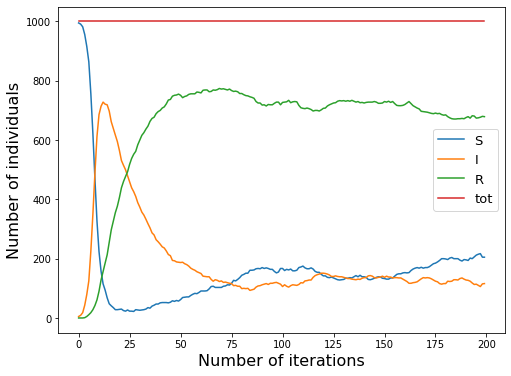

In [9]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S, label = 'S')
plt.plot(indexes, I, label = 'I')
plt.plot(indexes, R, label = 'R')
plt.plot(indexes, S+I+R, label = 'tot')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

## Commuting over networks

Simplifying assumptions:
* $N_i = N_j$
* $N_{ij} = N_{ji} $

In [10]:
Nij = int(p_mob*N)
print("Number of individuals travelling from each network: ", Nij)
N_tot = N + Nij # same for the two networks

Number of individuals travelling from each network:  50


In [11]:
travellers_sf = np.random.choice(np.arange(N), size=Nij, replace=False)
travellers_er = np.random.choice(np.arange(N), size=Nij, replace=False)

# this travellers will be numbered starting from N when they are at work 
#(but we need to know what are their identities in the original system)
new_ids_sf = {} # fixed for the entire simulation ! (no need for performance)
for i, ID in enumerate(travellers_sf):
    new_ids_sf[i+N] = ID
new_ids_er = {} # fixed for the entire simulation ! (no need for performance)
for i, ID in enumerate(travellers_er):
    new_ids_er[i+N] = ID

In [12]:
mob_mask_sf = np.isin(np.arange(N), travellers_sf)
A_sf_stay = np.copy(A_sf)
A_sf_stay[mob_mask_sf,:] = 0
A_sf_stay[:,mob_mask_sf] = 0
G_sf_stay = nx.from_numpy_matrix(A_sf_stay)

mob_mask_er = np.isin(np.arange(N), travellers_er)
A_er_stay = np.copy(A_er)
A_er_stay[mob_mask_er,:] = 0
A_er_stay[:,mob_mask_er] = 0
G_er_stay = nx.from_numpy_matrix(A_er_stay)

Now we need to get the degrees of the travellers, because we assume that they will form the same number of connections also in the other network (approximately).

In [13]:
deg_sf = [k for n,k in G_sf.degree(travellers_sf)]
deg_er = [k for n,k in G_sf.degree(travellers_er)]

In [14]:
def attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot):
    """Attach new travellers using preferential attachment and keeping their original degrees."""
    edge_list_sf = list(G_sf_stay.edges)
    for i,ID in enumerate(new_ids_er.keys()):
        k = deg_er[i]
        indexes = np.random.choice(len(edge_list_sf), size=k, replace=False)
        #targets = []
        for j in indexes:
            trg = np.random.choice(list(edge_list_sf[j]))
            #if trg in targets:
            edge_list_sf.append((ID,trg))
            
    G_sf_day = nx.Graph(edge_list_sf)
    # add also the nodes without edges to get the known dimension N_tot
    G_sf_day.add_nodes_from(np.arange(N_tot))
    A_sf_day = nx.to_numpy_matrix(G_sf_day, nodelist=np.arange(N_tot))
    
    return G_sf_day, A_sf_day

Note: in this function it can happen that the same node is chosen more than once from the same travellers. This implies that sometimes there are less connections than expected and this happens very frequently with the nodes with higher degree. Also it can happen that they increase their number of connections because some other traveller chooses to connect with them! 

(If you want you can try to fix it!)

Also there is to implement the random attachment instead of the preferential one, where you pick directly a node at random between those that stay in the system (this needs to be checked, so you will need also the travellers from the system to check the departures).

In [15]:
# call the function
G_sf_day, _ = attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot)

In [16]:
### just for debugging purposes ###

real_deg = G_sf_day.degree(new_ids_er.keys())

for i,k in enumerate(deg_er):
    print("Original vs real degree: %d\t%d"%(k,real_deg[i+N])) 

Original vs real degree: 2	2
Original vs real degree: 3	4
Original vs real degree: 2	2
Original vs real degree: 6	6
Original vs real degree: 3	4
Original vs real degree: 2	2
Original vs real degree: 3	4
Original vs real degree: 2	2
Original vs real degree: 10	11
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 3	3
Original vs real degree: 2	2
Original vs real degree: 2	3
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 3	3
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 24	26
Original vs real degree: 2	2
Original vs real degree: 5	5
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 5	5
Original vs real degree: 6	7
Original vs real degree: 2	2
Original vs real degree: 2	2
Original vs real degree: 3	3
Original vs real degree: 2	2
Original vs real degree: 3	3
Original v

In [17]:
A_sf_day = nx.to_numpy_matrix(G_sf_day, nodelist=np.arange(N_tot))

# debug 
A_sf_day[1000,:].sum() # real degree of the first traveller (see cell above)

2.0

Extracting the state of the travellers 

In [28]:
# prepare states just for trying things
state_sf = prepare_init_state(N,I0)
state_er = prepare_init_state(N,I0)

In [26]:
state_sf_trav = state_sf[travellers_sf]
print("state_sf_trav.shape: ", state_sf_trav.shape)
state_er_trav = state_er[travellers_er]

# then concatenate them during the "day"
state_sf_day = np.concatenate((state_sf, state_er_trav))
print("state_sf_day.shape: ", state_sf_day.shape)
state_er_day = np.concatenate((state_er, state_sf_trav))

# we also need masks to cancel the contribution of the people that are not in the system during the day
# we already done that before, but for range N instead of N_tot

mob_mask_sf = (~np.isin(np.arange(N_tot), travellers_sf)).astype(int)
print("mob_mask_sf.shape: ", mob_mask_sf.shape)
mob_mask_er = (~np.isin(np.arange(N_tot), travellers_er)).astype(int)

state_sf_trav.shape:  (50, 3)
state_sf_day.shape:  (1050, 3)
mob_mask_sf.shape:  (1050,)


Now we need to modify the SIRS dynamics masking out the absent people. This should work for the day, whereas for the night we simply use the original system.

In [30]:
A = A_sf_day 
state = state_sf_day
masked_susceptible = state[:,1]*mob_mask_sf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
print("Indices of the travellers: \n", travellers_sf)
print("Indices of the infected: \n", np.where(state[:,1] == 1))
# 0 means that the infected is not present in the system
print("Infected present in the system: \n", masked_susceptible[np.where(state[:,1] == 1)]) 

Indices of the travellers: 
 [ 30 586 664 648 825 500   0 352 584 553 324 996 679 301 635 986 779 555
 452 457 320 658 361 966   5 650  46 207 637 354 195 580 126 863 449  97
 928 245 550 246 185 904 257 845 874 909 913 454  11 235]
Indices of the infected: 
 (array([665, 679, 702, 920, 991]),)
Infected present in the system: 
 [1. 0. 1. 1. 1.]


The idea is that the only passage where we need to mask the absent infected is where we compute the interaction term between susceptible and infected. For the I->R and R->S transitions we can consider the travellers virtually present for the sake of simplicity and just overwrite their state with the correct one obtained from the other system (because they are present as travellers there in the meantime).

In [39]:
def SIRS_masked_step(A, state, mask, beta, mu, gamma, T=0.5, debug=False):
    """
    SIRS step for a single network. Updated A and state needs to be computed
    before calling this function (take into account mobility + dynamic contacts).
    Works with synchronous update (e.g. new infected cannot recover in this step).
    
    Parameters
    ----------
    - A : adjacency matrix
    - state : 
        state[:,0] = 1 for the susceptible, 0 for the others
        state[:,1] = 1 for the infected, 0 for the others
        state[:,2] = 1 for the recovered, 0 for the others
    - mask : True at index i if that node is present in the system at current step
    - beta : prob of infection given contact
    - mu : prob of recovery per step
    - gamma : prob of S->R transition per step
    - T : fraction of the day spent in the system
    
    Return
    ------
    state, recovered (updated)
    """
    N = len(state)
    new_state = np.zeros((N,3))
    
    dprint = print if debug else lambda *args, **kwargs : None
        
    ### S -> I ###
    p_I = beta*np.matmul(A,state[:,1]*mask).T # prob of getting the infection
    p_I = np.array(p_I).reshape(N)
    u = np.random.rand(N) 
    mask_S = (u < p_I*state[:,0]) # apply only to susceptible
    new_state[mask_S,1] = 1
    state[mask_S,0] = 0
    
    dprint("New I: ", new_state[:,1].sum())
    
    ### I -> R ###
    u = np.random.rand(N) 
    mask_I = (u < mu*state[:,1]) # apply only to infected
    new_state[mask_I,2] = 1
    state[mask_I,1] = 0
    
    dprint("New R: ", new_state[:,2].sum())
    
    ### R -> S ###
    u = np.random.rand(N) 
    mask_R = (u < gamma*state[:,2]) # apply only to recovered
    new_state[mask_R,0] = 1
    state[mask_R,2] = 0
    
    dprint("New S: ", new_state[:,0].sum())
    
    state = state + new_state
    
    dprint("Updated S: ", state[:,0].sum())
    dprint("Updated I: ", state[:,1].sum())
    dprint("Updated R: ", state[:,2].sum())
    
    return state

In [42]:
def two_sys_full_SIRS_step(state_sf, state_er, travellers_sf, travellers_er, new_ids_sf, new_ids_er, 
                           deg_sf, deg_er, A_sf, A_er, G_sf_stay, G_er_stay, beta, mu, gamma):
    """ ADD DDESCRIPTION """
    N = len(state_sf)
    Nij = len(travellers_sf)
    N_tot = N + Nij
    
    ### day ###
    
    # compute day networks
    _, A_sf_day = attach_travellers(G_sf_stay, new_ids_er, deg_er, N_tot)
    _, A_er_day = attach_travellers(G_er_stay, new_ids_sf, deg_sf, N_tot)
    
    # mobility masks (True if present, False if travelling)
    mob_mask_sf = (~np.isin(np.arange(N_tot), travellers_sf)).astype(int)
    mob_mask_er = (~np.isin(np.arange(N_tot), travellers_er)).astype(int)
    
    # states of the travellers
    state_sf_trav = state_sf[travellers_sf]
    state_er_trav = state_er[travellers_er]

    # stay + travellers of the other system state 
    # also absent travellers are virtually present - that is why we use masks
    state_sf_day = np.concatenate((state_sf, state_er_trav))
    state_er_day = np.concatenate((state_er, state_sf_trav))
    
    # make day SIRS step
    state_sf_day = SIRS_masked_step(A_sf_day, state_sf_day, mob_mask_sf, beta, mu, gamma)
    state_er_day = SIRS_masked_step(A_er_day, state_er_day, mob_mask_er, beta, mu, gamma)
    
    # extract the state of the travellers
    state_sf_trav = state_er_day[N:] 
    state_er_trav = state_sf_day[N:] 

    # overwrite them into the original system 
    state_sf[travellers_sf] = state_sf_trav
    state_er[travellers_sf] = state_er_trav
    
    ### night ###
    
    # make SIRS step
    state_sf = SIRS_step(A_sf, state_sf, beta, mu, gamma)
    state_er = SIRS_step(A_er, state_er, beta, mu, gamma)
    
    return state_sf, state_er

In [66]:
def prepare_two_sys(N, I_sf, I_er, p_mob, mean_degree):
    
    ### Topology ###
    
    p = mean_degree/N # prob of creating an edge
    
    # create networks
    G_sf = nx.barabasi_albert_graph(N,int(mean_degree/2))
    G_er = nx.binomial_graph(N,p)
    
    # get adjacency matrices
    A_sf = nx.to_numpy_matrix(G_sf)
    A_er = nx.to_numpy_matrix(G_er)
    
    ### Initial state ###
    
    state_sf = prepare_init_state(N,I_sf)
    state_er = prepare_init_state(N,I_er)
    
    ### Mobility part ### 
    
    Nij = int(p_mob*N) # number of travellers for each system
    
    # Choose travellers IDs
    travellers_sf = np.random.choice(np.arange(N), size=Nij, replace=False)
    travellers_er = np.random.choice(np.arange(N), size=Nij, replace=False)
    
    # Map the travellers IDs in the other system as N, N+1,...,N+Nij-1
    new_ids_sf = {} 
    for i, ID in enumerate(travellers_sf):
        new_ids_sf[i+N] = ID
    new_ids_er = {} 
    for i, ID in enumerate(travellers_er):
        new_ids_er[i+N] = ID
        
    # Compute the adjacency matrices and the networks of the remainers
    mob_mask_sf = np.isin(np.arange(N), travellers_sf)
    A_sf_stay = np.copy(A_sf)
    A_sf_stay[mob_mask_sf,:] = 0
    A_sf_stay[:,mob_mask_sf] = 0
    G_sf_stay = nx.from_numpy_matrix(A_sf_stay)

    mob_mask_er = np.isin(np.arange(N), travellers_er)
    A_er_stay = np.copy(A_er)
    A_er_stay[mob_mask_er,:] = 0
    A_er_stay[:,mob_mask_er] = 0
    G_er_stay = nx.from_numpy_matrix(A_er_stay)
    
    # Compute the original degrees of the travellers
    deg_sf = [k for n,k in G_sf.degree(travellers_sf)]
    deg_er = [k for n,k in G_sf.degree(travellers_er)]
    
    # wrap variables in dictionaries 
    variables_net_sf = {'travellers_sf':travellers_sf, 'new_ids_sf':new_ids_sf, 'deg_sf':deg_sf,
                        'A_sf':A_sf, 'G_sf_stay':G_sf_stay }

    variables_net_er = {'travellers_er':travellers_er, 'new_ids_er':new_ids_er, 'deg_er':deg_er,
                        'A_er':A_er, 'G_er_stay':G_er_stay }
    
    return state_sf, state_er, variables_net_sf, variables_net_er

### Test

In [73]:
# parameters
N = 1000
I_sf = 5
I_er = 2
p_mob = 0.05
mean_degree = 4
eps = 0.1
beta = 0.09
mu = 0.08 # change this, it's the most unreasonable estimate
gamma = 0.01

In [70]:
# prepare systems
state_sf, state_er, variables_net_sf, variables_net_er = prepare_two_sys(N, I_sf, I_er, p_mob, mean_degree)

In [74]:
infection_params = dict(beta=beta, mu=mu, gamma=gamma)
infection_params

{'beta': 0.09, 'mu': 0.08, 'gamma': 0.01}

In [72]:
state_sf, state_er = two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                            **variables_net_er, **infection_params)

In [75]:
import time 
start = time.time()
n_iter = 1000
S_sf = []
I_sf = []
R_sf = []
S_er = []
I_er = []
R_er = []
t_vec = []
for i in range(n_iter):
    state_sf, state_er = two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                            **variables_net_er, **infection_params)
    S_sf.append(state_sf[:,0].sum())
    I_sf.append(state_sf[:,1].sum())
    R_sf.append(state_sf[:,2].sum())
    S_er.append(state_er[:,0].sum())
    I_er.append(state_er[:,1].sum())
    R_er.append(state_er[:,2].sum())
    t_vec.append(time.time()-start)
    
tot_time = time.time()-start
print("Total time elapsed: %.2f s"%tot_time)
print("Time per iteration: %.4f s"%(tot_time/n_iter))

S_sf = np.array(S_sf)
I_sf = np.array(I_sf)
R_sf = np.array(R_sf)
S_er = np.array(S_er)
I_er = np.array(I_er)
R_er = np.array(R_er)
t_vec = np.array(t_vec)

Total time elapsed: 66.19 s
Time per iteration: 0.0662 s


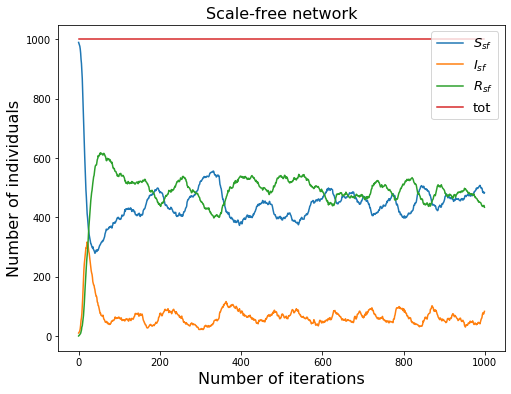

In [78]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S_sf, label = r'$S_{sf}$')
plt.plot(indexes, I_sf, label = r'$I_{sf}$')
plt.plot(indexes, R_sf, label = r'$R_{sf}$')
plt.plot(indexes, S_sf+I_sf+R_sf, label = 'tot')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.title("Scale-free network", fontsize = 16)
plt.legend(fontsize=13, loc='upper right')
plt.show()

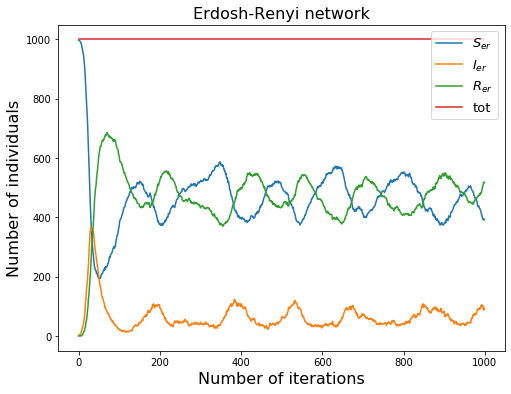

In [79]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S_er, label = r'$S_{er}$')
plt.plot(indexes, I_er, label = r'$I_{er}$')
plt.plot(indexes, R_er, label = r'$R_{er}$')
plt.plot(indexes, S_er+I_er+R_er, label = 'tot')
plt.title("Erdosh-Renyi network", fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.legend(fontsize=13, loc='upper right')
plt.show()